In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [536]:
from matplotlib.transforms import Affine2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from collections import namedtuple
from copy import deepcopy
from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture

import seaborn as sns
sns.set()
sns.set_style('whitegrid')

(-3, 3)

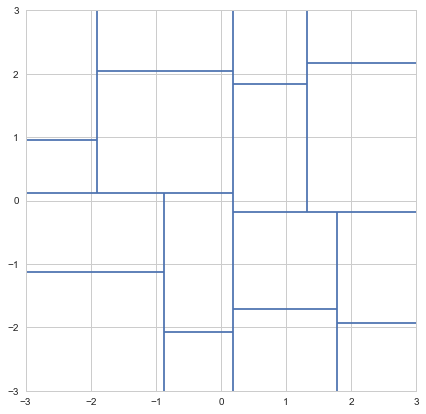

In [518]:
Box = namedtuple('Box', ['left', 'right', 'top', 'bottom'])
class Box:
    __slots__ = ['left', 'right', 'top', 'bottom']
    def __init__(self, left=-1, right=1, top=1, bottom=-1):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        
    def __repr__(self):
        return 'Box(left={}, right={}, top={}, bottom={})'.format(
            self.left, self.right, self.top, self.bottom)

    @property
    def width(self):
        return self.right - self.left

    @property
    def height(self):
        return self.top - self.bottom

    @property
    def x(self):
        return 0.5*(self.left + self.right)
    
    @property
    def y(self):
        return 0.5*(self.top + self.bottom)
    
def random_split(lines=None, boxes=None, box=None, vertical=True, max_depth=5):
    '''
        box: [left, right, top, bottom]
    '''
    if lines is None:
        lines = []
    if box is None:
        box = Box(left=-3, right=3, top=3, bottom=-3)
    if boxes is None:
        boxes = []
    if max_depth <= 0:
        boxes.append(box)
        return
    if vertical:
        box_width = box.right - box.left
        s = np.random.uniform(box.left + box_width*0.25,
                              box.right - box_width*0.25)
        box_right = deepcopy(box)
        box_right.left = s
        lines.append([[s, box.bottom], [s, box.top]])
        random_split(lines, boxes, box_right, vertical=False, max_depth=max_depth - 1)
        box_left = deepcopy(box)
        box_left.right = s
        random_split(lines, boxes, box_left, vertical=False, max_depth=max_depth - 1)
    else:
        box_height = box.top - box.bottom
        s = np.random.uniform(box.bottom + box_height*0.25, 
                              box.top - box_height*0.25)
        box_top = deepcopy(box)
        box_top.bottom = s
        lines.append([[box.left, s], [box.right, s]])
        random_split(lines, boxes, box_top, vertical=True, max_depth=max_depth - 1)
        box_bottom = deepcopy(box)
        box_bottom.top = s
        random_split(lines, boxes, box_bottom, vertical=True, max_depth=max_depth - 1)
    
    return lines, boxes

fig, ax = plt.subplots(figsize=(7, 7))
lines, boxes = random_split(max_depth=4)
ax.add_collection(LineCollection(lines))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

In [534]:
palette = [list(a) + [1.0] for a in sns.color_palette('Set2', 12)]

(-3, 3)

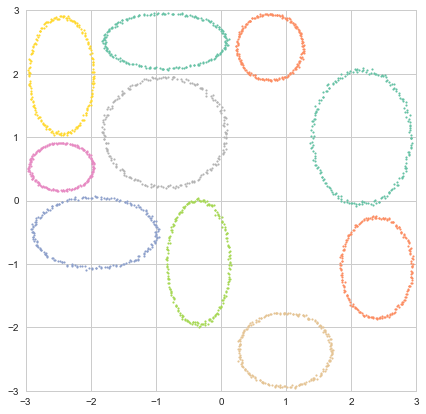

In [539]:
def ellipse(N=200, noise=0.02):
    #t = np.cumsum(np.random.uniform(size=n_points))
    #t /= 2*np.pi/t[-1]
    t = np.linspace(0, 2*np.pi, N)
    x = np.cos(t) + np.random.normal(scale=noise, size=N)
    y = np.sin(t) + np.random.normal(scale=noise, size=N)
    return x, y

def random_transform(X):
    affine = Affine2D()
    affine.scale(np.random.uniform(0.2, 1), np.random.uniform(0.2, 1))
    affine.rotate(np.random.uniform(2*np.pi))
    affine.translate(np.random.uniform(-2, 2), np.random.uniform(-2, 2))
    X = affine.transform(X)
    return X

def transform_into_box(X, box):
    affine = Affine2D()
    affine.scale(box.width*0.45, box.height*0.45)
    affine.translate(box.x, box.y)
    X = affine.transform(X)
    return X
    
fig, ax = plt.subplots(figsize=(7, 7))
selected_boxes = [boxes[i] for i in np.random.choice(len(boxes), size=10, replace=False)]
X = []
for i in range(10):
    X_i = np.column_stack(ellipse())
    #X = random_transform(X)
    X_i = transform_into_box(X_i, selected_boxes[i])
    ax.scatter(X_i[:, 0], X_i[:, 1], s=3, label=str(i), c=[palette[i]])
    X.append(X_i)
X = np.concatenate(X, axis=0)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
#ax.legend()

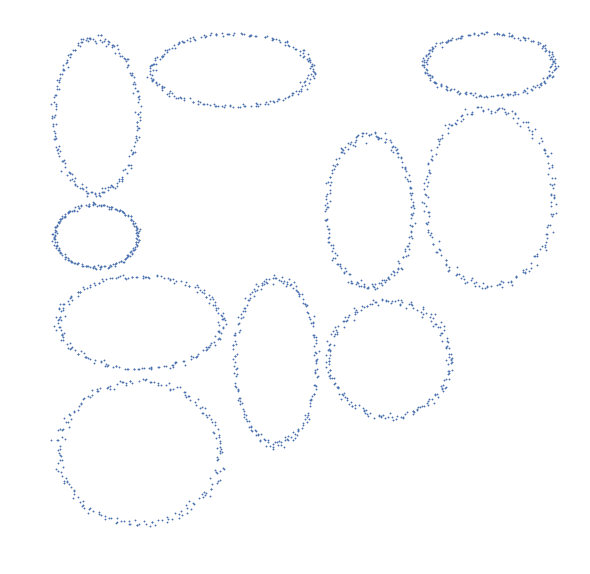

In [520]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=2)
ax.set_axis_off()
plt.savefig('circles.png')

(-3, 3)

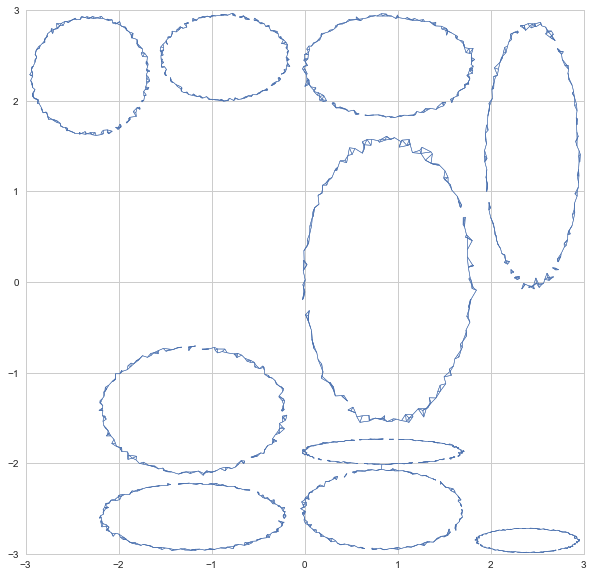

In [430]:
nn = NearestNeighbors(4)
nn.fit(X)
nn_graph = nn.kneighbors_graph(X).toarray()

#nn = NearestNeighbors(radius=0.12)
#nn.fit(X)
#nn_graph = nn.radius_neighbors_graph(X).toarray()
nn_graph = np.minimum(nn_graph + nn_graph.T, 1.0)
nn_graph[np.r_[:X.shape[0]], np.r_[:X.shape[0]]] = 0
L = graph_laplacian(nn_graph)
eigvals, eigvecs = np.linalg.eigh(L)

ii, jj = np.nonzero(nn_graph)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(LineCollection(np.concatenate([X[ii, np.newaxis, :], X[jj, np.newaxis, :]], axis=1),
                                 linewidths=0.5))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

In [396]:
eigvals[:20]

array([-2.48654762e-16, -1.37689002e-16, -9.62039510e-17, -3.60360028e-17,
        1.99052088e-17,  3.35112309e-17,  5.66788092e-17,  1.41333080e-16,
        5.88504173e-04,  6.95404258e-04,  1.89782418e-03,  2.08935787e-03,
        2.16233841e-03,  2.16989012e-03,  2.24555836e-03,  2.30101127e-03,
        2.34717541e-03,  2.34814987e-03,  2.35867559e-03,  2.38417207e-03])

(0, 500)

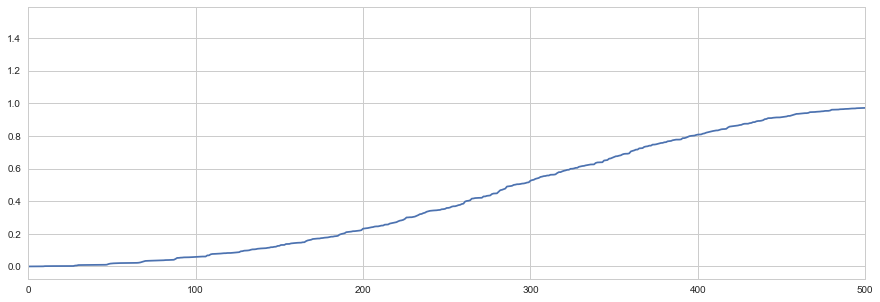

In [394]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(eigvals)
ax.set_xlim(0, 500)

In [414]:
sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Pastel1', 'Pastel2', 'Dark2'), value='Set1'), IntSlider(value=9, description='n', max=16, min=2), FloatSlider(value=1.0, description='desat', max=1.0), Output()), _dom_classes=('widget-interact',))

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

In [419]:
sns.color_palette?

In [426]:
sns.color_palette('Set1', 10)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

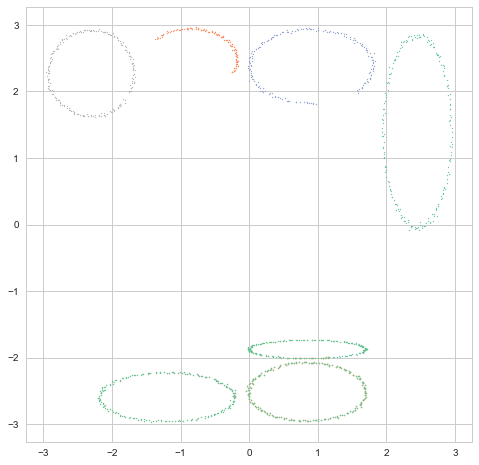

In [431]:
fig, ax = plt.subplots(figsize=(8, 8))
n_clusters = 10
labels = np.full(X.shape[0], -1, np.int32)
palette = [list(a) + [1.0] for a in sns.color_palette('Set2', 10)]
for label in range(n_clusters):
    indices = np.nonzero(np.abs(eigvecs[:, label]))[0]
    labels[indices] = i
    ax.scatter(X[indices, 0], X[indices, 1], s=1, label=str(label), 
               c=[palette[label]])

In [446]:
palette

[[0.4, 0.7607843137254902, 0.6470588235294118, 1.0],
 [0.9882352941176471, 0.5529411764705883, 0.3843137254901961, 1.0],
 [0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0],
 [0.9058823529411765, 0.5411764705882353, 0.7647058823529411, 1.0],
 [0.6509803921568628, 0.8470588235294118, 0.32941176470588235, 1.0],
 [1.0, 0.8509803921568627, 0.1843137254901961, 1.0],
 [0.8980392156862745, 0.7686274509803922, 0.5803921568627451, 1.0],
 [0.7019607843137254, 0.7019607843137254, 0.7019607843137254, 1.0],
 [0.4, 0.7607843137254902, 0.6470588235294118, 1.0],
 [0.9882352941176471, 0.5529411764705883, 0.3843137254901961, 1.0]]

/home/shibinbin/apps/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(-3, 3)

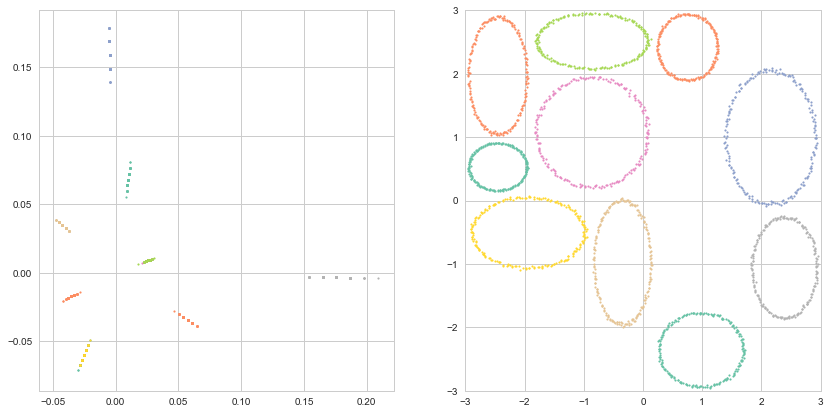

In [542]:
#nn = NearestNeighbors(radius=0.05)
#nn.fit(X)
#affinity = nn.radius_neighbors_graph(X).toarray()
#affinity = 0.5*(affinity + affinity.T)

nn = NearestNeighbors(9)
nn.fit(X)
affinity = nn.kneighbors_graph(X).toarray()
affinity = 0.5*(affinity + affinity.T)

X_embed = SpectralEmbedding(n_components=5, affinity='precomputed').fit_transform(affinity)
#X_embed = SpectralEmbedding(n_components=2, n_neighbors=7).fit_transform(X)
#X_embed = SpectralEmbedding(n_components=3, affinity='rbf', gamma=1.0).fit_transform(X)

n_clusters = 10
#labels = KMeans(n_clusters).fit(X_embed).labels_
labels = GaussianMixture(n_clusters, n_init=10, reg_covar=1e-5).fit(X_embed).predict(X_embed)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for label in range(n_clusters):
    indices = np.nonzero(labels == label)[0]
    axes[0].scatter(X_embed[indices, 0], X_embed[indices, 1], s=3, 
                    label=str(label), c=[palette[label]])
    axes[1].scatter(X[indices, 0], X[indices, 1], s=3, 
                    label=str(label), c=[palette[label]])
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
#axes[1].legend()

In [510]:
grid_x, grid_y = np.mgrid[-3:3:0.02, -3:3:0.02]
logp = KernelDensity(bandwidth=0.05).fit(X).score_samples(np.column_stack([grid_x.flatten(), grid_y.flatten()]))
logp = logp.reshape(grid_x.shape)

In [511]:
logp.shape

(300, 300)

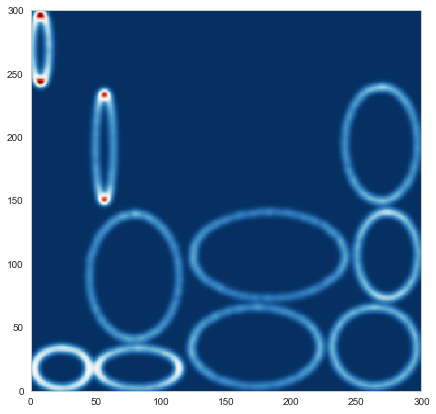

In [512]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.pcolor(np.exp(logp), cmap=cm.RdBu_r)

In [237]:
def graph_laplacian(X):
    N = X.shape[0]
    D = np.sum(X, axis=0)
    D2 = np.zeros(N)
    nonzero_mask = ~np.isclose(D, 0)
    D2[nonzero_mask] = 1.0/np.sqrt(D[nonzero_mask])
    D2 = np.diag(D2)
    #L = -X.copy()
    #L[np.r_[:N], np.r_[:N]] += D
    #L = D - X
    #D2 = np.sqrt(1.0/D)
    #L *= D2[:, np.newaxis]*D2[np.newaxis, :]
    return np.identity(N) - D2.dot(X).dot(D2)

In [253]:
L.sum(axis=0)

array([ 9.17517095e-02,  9.17517095e-02,  2.22044605e-16, ...,
       -1.49829914e-01,  1.46446609e-01,  1.83503419e-01])

In [250]:
nn = NearestNeighbors(3)
nn.fit(X)
nn_graph = nn.kneighbors_graph(X).toarray()
nn_graph = np.minimum(nn_graph + nn_graph.T, 1.0)
nn_graph[np.r_[:X.shape[0]], np.r_[:X.shape[0]]] = 0
L = graph_laplacian(nn_graph)
eigvals, eigvecs = np.linalg.eigh(L)

In [251]:
np.nonzero(~np.isclose(nn_graph, nn_graph.T))[0].shape

(0,)

In [252]:
np.sum(nn_graph, axis=0)

array([2., 2., 2., ..., 3., 2., 2.])

In [254]:
eigvals

array([-2.17167401e-15, -1.94988358e-15, -1.93122067e-15, ...,
        1.94694728e+00,  1.94697330e+00,  1.98190572e+00])

(-3, 3)

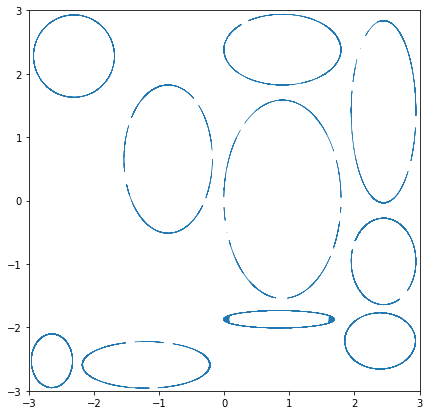

In [335]:
#nn = NearestNeighbors(6)
#nn.fit(X)
#nn_graph = nn.kneighbors_graph(X).toarray()
nn = NearestNeighbors(radius=0.12)
nn.fit(X)
nn_graph = nn.radius_neighbors_graph(X).toarray()
nn_graph = np.minimum(nn_graph + nn_graph.T, 1.0)
nn_graph[np.r_[:X.shape[0]], np.r_[:X.shape[0]]] = 0
L = graph_laplacian(nn_graph)
eigvals, eigvecs = np.linalg.eigh(L)

ii, jj = np.nonzero(nn_graph)
fig, ax = plt.subplots(figsize=(7, 7))
ax.add_collection(LineCollection(np.concatenate([X[ii, np.newaxis, :], X[jj, np.newaxis, :]], axis=1),
                                 linewidths=0.5))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

(0, 1000)

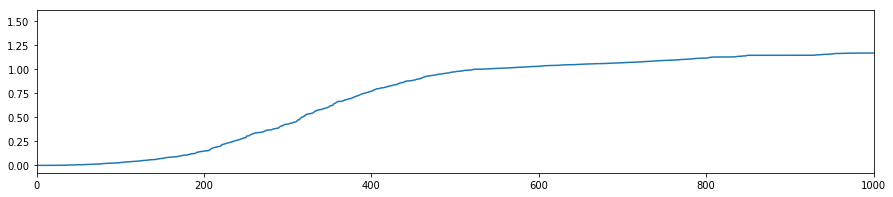

In [274]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(eigvals)
ax.set_xlim(0, 1000)

In [214]:
eigvecs.shape

(2000, 2000)

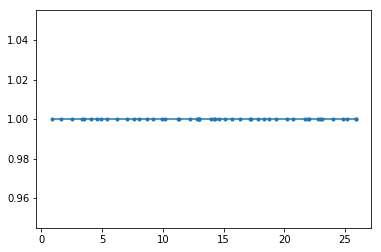

In [13]:
N = 50
x = np.cumsum(np.random.uniform(size=N))
y = np.ones(N)
plot(x, y, marker='.')

(-3, 3)

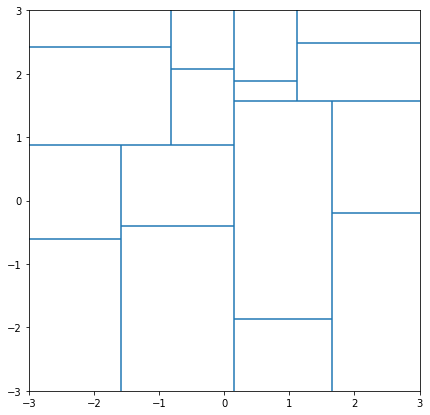

In [121]:
Box = namedtuple('Box', ['left', 'right', 'top', 'bottom'])
class Box:
    __slots__ = ['left', 'right', 'top', 'bottom']
    def __init__(self, left=-1, right=1, top=1, bottom=-1):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        
    def __repr__(self):
        return 'Box(left={}, right={}, top={}, bottom={})'.format(
            self.left, self.right, self.top, self.bottom)

    @property
    def width(self):
        return self.right - self.left

    @property
    def height(self):
        return self.top - self.bottom

    @property
    def x(self):
        return 0.5*(self.left + self.right)
    
    @property
    def y(self):
        return 0.5*(self.top + self.bottom)
    
def random_split(lines=None, boxes=None, box=None, vertical=True, max_depth=5):
    '''
        box: [left, right, top, bottom]
    '''
    if lines is None:
        lines = []
    if box is None:
        box = Box(left=-3, right=3, top=3, bottom=-3)
    if boxes is None:
        boxes = []
    if max_depth <= 0:
        return
    if vertical:
        box_width = box.right - box.left
        s = np.random.uniform(box.left + box_width*0.2,
                              box.right - box_width*0.2)
        box_right = deepcopy(box)
        box_right.left = s
        lines.append([[s, box.bottom], [s, box.top]])
        boxes.append(box_right)
        random_split(lines, boxes, box_right, vertical=False, max_depth=max_depth - 1)
        box_left = deepcopy(box)
        box_left.right = s
        boxes.append(box_left)
        random_split(lines, boxes, box_left, vertical=False, max_depth=max_depth - 1)
    else:
        box_height = box.top - box.bottom
        s = np.random.uniform(box.bottom + box_height*0.2, 
                              box.top - box_height*0.2)
        box_top = deepcopy(box)
        box_top.bottom = s
        lines.append([[box.left, s], [box.right, s]])
        boxes.append(box_top)
        random_split(lines, boxes, box_top, vertical=True, max_depth=max_depth - 1)
        box_bottom = deepcopy(box)
        box_bottom.top = s
        boxes.append(box_bottom)
        random_split(lines, boxes, box_bottom, vertical=True, max_depth=max_depth - 1)
    
    return lines, boxes

fig, ax = plt.subplots(figsize=(7, 7))
lines, boxes = random_split(max_depth=4)
ax.add_collection(LineCollection(lines))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

In [434]:
class Object(object):
    def __init__(self, data):
        self._data = data
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, data):
        self._data = data
        
o = Object(1)
o.data = 2
print(o)